In [171]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

import nltk
import pandas as pd
from sklearn.utils import shuffle
from nltk.tokenize import word_tokenize, sent_tokenize, wordpunct_tokenize, regexp_tokenize, TweetTokenizer
from nltk.probability import FreqDist

from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
import string
from matplotlib.pyplot import figure

From the google play store we have scraped reviews for grocery store apps delivery apps: Tesco, Morrisons, M&S, ASDA, Aldi, Sainbury's and Waitrose. Parameters for scraping were set to 300 for reviews with 1 and 2 stars and 250 for 4, and 5 stars and only 150 with 3 stars.

In [3]:
app_reviews_df = pd.read_csv("src/reviews.csv")
app_infos_df = pd.read_csv("src/apps.csv")

## EDA

<ol>
    <li>Check the number of reviews scraped for each company</li>
</ol>

In [4]:
apps = app_reviews_df['appId'].unique()

In [68]:
def check_reviews_per_star(df):
    apps = df['appId'].unique()
    for app in apps:
        name = app.split('.')[1].title() if app != 'de.apptiv.business.android.aldi_uk' else app.split('.')[-1].split('_')[0].title()
        print(name, "reviews per star:")
        stars = df['score'].loc[df['appId'] == app].value_counts()
        total = sum(stars)
        print(stars)
        print('Total # of reviews:',total)
        print('\n')

In [69]:
check_reviews_per_star(app_reviews_df)

Tesco reviews per star:
1    300
2    300
4    250
5    250
3    150
Name: score, dtype: int64
Total # of reviews: 1250


Morrisons reviews per star:
1    300
5    250
2    119
4     86
3     80
Name: score, dtype: int64
Total # of reviews: 835


Marksandspencer reviews per star:
1    300
2    300
4    250
5    250
3    150
Name: score, dtype: int64
Total # of reviews: 1250


Asda reviews per star:
1    300
2    300
4    250
5    250
3    150
Name: score, dtype: int64
Total # of reviews: 1250


Aldi reviews per star:
1    300
2    280
4    250
5    250
3    150
Name: score, dtype: int64
Total # of reviews: 1230


Sainsburys reviews per star:
1    300
2    300
4    250
5    250
3    150
Name: score, dtype: int64
Total # of reviews: 1250


Waitrose reviews per star:
1    300
4    250
5    250
3    130
2    115
Name: score, dtype: int64
Total # of reviews: 1045




From the reviews, Morrisons and Waitrose scraped less reviess with 3,2, and 4 stars due to availability however at the extremes (1 and 5 stars) it's the same as others - as expected. As we aim to extract recommendations, the 1 star reviews will have vital importance however we proceed with cautions given the lower sample size relative to other apps.

<ol start='2'>
    <li>Check for missing values</li>

In [7]:
for column in app_reviews_df.columns:
    print("Missing values in", column, ": {}".format(app_reviews_df[column].isnull().sum()))

Missing values in reviewId : 0
Missing values in userName : 0
Missing values in userImage : 0
Missing values in content : 0
Missing values in score : 0
Missing values in thumbsUpCount : 0
Missing values in reviewCreatedVersion : 762
Missing values in at : 0
Missing values in replyContent : 7963
Missing values in repliedAt : 7963
Missing values in sortOrder : 0
Missing values in appId : 0


In [8]:
app_reviews_df.loc[app_reviews_df['reviewCreatedVersion'] == '19.29.0'].head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOHoLYWCleX8HM-fJST-nS6_Q7nRCKgUfcXviZW...,Joyce Jamieson,https://play-lh.googleusercontent.com/a/AATXAJ...,Found this confusing and difficult,1,0,19.29.0,2022-03-31 16:48:34,NaN,NaN,newest,com.tesco.grocery.view
1,gp:AOqpTOEALmLSsWoRa5iIEtmENfRtPkvS3O-W7NvitLW...,Alistair Charles,https://play-lh.googleusercontent.com/a/AATXAJ...,Rubbish app. Forgets changes to orders.,1,0,19.29.0,2022-03-30 21:37:56,NaN,NaN,newest,com.tesco.grocery.view
2,gp:AOqpTOGosMLyacp8xUArioSjY5_628L0xxBJ3BmgTtC...,John Hirst,https://play-lh.googleusercontent.com/a/AATXAJ...,"Rubbish, constantly asking to resign in",1,0,19.29.0,2022-03-30 17:31:00,NaN,NaN,newest,com.tesco.grocery.view
4,gp:AOqpTOGsEOuB5kASf1CwHBp8-DfEzUIjwppVtIJJL9e...,Hey Boo,https://play-lh.googleusercontent.com/a/AATXAJ...,"Got to be a better way to do it, I search for ...",1,0,19.29.0,2022-03-30 08:11:54,NaN,NaN,newest,com.tesco.grocery.view
5,gp:AOqpTOHbEWaEPaarmEliv8pp21O7EmHJ618AM_Etw9b...,Stephen Wren,https://play-lh.googleusercontent.com/a-/AOh14...,Negative stars! World's most annoying app. End...,1,4,19.29.0,2022-03-29 22:11:17,NaN,NaN,newest,com.tesco.grocery.view


Further inspection shows that 'reviewCreatedVersion' is the version of the app the user reviewed. Therefore, we can potentially narrow down the comments by the version of the app rather than dates. Alternatively, I can use the date as a proxy for the created version so will keep those. Regarding the replyContent and repliedAt, doesn't really matter as these just represent whether the company replied or not but worth visualising just in case. 

In [9]:
app_reviews_df.loc[app_reviews_df['replyContent'].notnull()]['appId'].value_counts()

com.waitrose.groceries                101
de.apptiv.business.android.aldi_uk     25
com.marksandspencer.app                12
com.tesco.grocery.view                  4
com.sainsburys.gol                      3
com.morrisons.mobile.android            2
Name: appId, dtype: int64

We can see that waitrose is significantly better at replying to comment, with the next company being aldi (a budget supermaket) surprisingly. Aldi, on the other hand, has not replied to anyone. Next questions is, are they replying to good reviews or bad reviews?

In [10]:
for app in apps:
    print(app)
    print(app_reviews_df.loc[(app_reviews_df['appId'] == app) & (app_reviews_df['replyContent'].notnull() == True)]['score'].value_counts())
    print('\n')    

com.tesco.grocery.view
4    2
2    1
3    1
Name: score, dtype: int64


com.morrisons.mobile.android
4    1
5    1
Name: score, dtype: int64


com.marksandspencer.app
2    9
1    2
4    1
Name: score, dtype: int64


com.asda.android
Series([], Name: score, dtype: int64)


de.apptiv.business.android.aldi_uk
2    22
3     3
Name: score, dtype: int64


com.sainsburys.gol
2    1
4    1
5    1
Name: score, dtype: int64


com.waitrose.groceries
1    56
2    21
3    19
4     5
Name: score, dtype: int64




Waitrose mainly responds to low reviews <= 3 stars with most of the responses going to 1 star, M&S responds mainly to 2 and 1 stars, morrisons loves the praise only 4&5 stars. Aldi no reply to 1 stars but only to 2 and 3 stars. Tesco likes praise but has responded to a (1) 2 star and (1) 3 star review. Sainsburys also likes praise with 2 out of 3 responses going to 4 and 5 stars.

<ul>
    <li>Number of words per comment on avg.</li>
    <li>Number of sentences per comment on avg.</li>
</ul>

In [11]:
def sentence_segmentation(df):
    reviews_in_sents = []
    number_of_sents = 0
    for review in df['content']:
        sentences = nltk.sent_tokenize(review)
        number_of_sents += len(sentences)
        reviews_in_sents.append(sentences)
    return reviews_in_sents, number_of_sents

reviews_in_sents, number_of_sents = sentence_segmentation(app_reviews_df)
print(f'There is approx. {round(number_of_sents/len(reviews_in_sents),2)} sentences per review.')

There is approx. 1.92 sentences per review.


In [12]:
app_reviews_df['reviews_in_sents'] = reviews_in_sents

<ol start="3">
    <li>Check the date for the latest updated of the app and the number of reviews after the date.</li>
    <ul>
        <li>Tesco: <b>30 March 2022</b></li>
        <li>Morrison: <b>9 March 2022</b></li>
        <li>Marks and Spencers: <b>24 March 2022</b></li>    
        <li>ASDA: <b>29 March 2022</b></li>    
        <li>ALDI: <b>28 February 2022</b></li>    
        <li>Sainsbury's: <b>25 March 2022</b></li>    
        <li>Waitrose: <b>25 March 2022</b></li>
    </ul>
    <br>
   <li>Check what the recent changes made are.</li>
</ol>


In [13]:
i = 0
for changes in app_infos_df.iloc[:, 44]:
    name = app_infos_df['title'][i]
    print(name,'changes :', changes)
    i+= 1

Tesco Grocery & Clubcard changes : nan
Morrisons Groceries changes : We've made a few under-the-hood improvements for performance and security, and we've squashed a few bugs too.
M&S - Fashion, Food & Homeware changes : We’re constantly making improvements to the M&S app based on your feedback.
Make sure you update to benefit from the latest features.
ASDA changes : • Bug fixes and performance enhancements.
ALDI UK changes : We have made it easier for app users to view and purchase our latest grocery offers.
Sainsbury's Groceries changes : nan
Waitrose & Partners changes : nan


From the notes pertaining to the recent changes implemented to the apps, it's unclear if the existing reviews have been analysed as part of the process to create/improve features hence it will be difficult to know when an issue has been addressed by a new version of the app. In addittion, following the dates in which the apps were last updated we can't single out issue which are still present in the current version due to the lack of reviews from the date of update.

<ol start="5">
    <li>Check the date of the earliest review for each company.</li>
</ol>

In [15]:
app_reviews_df['appId'].unique()
for app in app_reviews_df['appId'].unique():
    name = app.split('.')[1].title() if app != 'de.apptiv.business.android.aldi_uk' else app.split('.')[-1].split('_')[0].title()
    date = app_reviews_df.loc[app_reviews_df['appId'] == app]['at'].min()  
    #print(type(date))
    print(name,':',date)

Tesco : 2021-10-18 20:21:20
Morrisons : 2013-12-23 21:30:41
Marksandspencer : 2019-12-24 15:49:00
Asda : 2020-01-30 07:08:11
Aldi : 2011-09-20 20:07:32
Sainsburys : 2020-07-15 08:26:40
Waitrose : 2018-11-01 13:40:30


Given that some apps have reviews as early as 2011, and given the lack of infomration related to information on changes made per version <b>I will narrow down the comments per company to include a maximum of the last 12 months.</b>

<ol start="6">
    <li>Check the comment with the most upvotes.</li>
</ol>

In [16]:
for app in apps:
    name = app.split('.')[1].title() if app != 'de.apptiv.business.android.aldi_uk' else app.split('.')[-1].split('_')[0].title()
    votes = app_reviews_df.loc[app_reviews_df['appId'] == app]['thumbsUpCount'].max()  
    review = app_reviews_df.loc[(app_reviews_df["appId"] == app) & (app_reviews_df["thumbsUpCount"] == votes), 'content'].value_counts()
    idx = app_reviews_df.loc[(app_reviews_df["appId"] == app) & (app_reviews_df["thumbsUpCount"] == votes), 'content'].index[0]
    date = app_reviews_df['at'][idx].split(' ')[0]
    print(name)
    print('Date published:', date, '    ', votes, 'likes' )
    print(review)
    print('\n')

Tesco
Date published: 2022-01-09      119 likes
Using favourites to shop is an issue. You cannot delete items from the list if you no longer need them, meaning the list becomes very long. Just recently it has begun to drop out of favourites, forcing you to go through the list several times to complete the order - which is frustrating. This is still not fixed months later. Update - still can't delete items, still keeps dropping out of favourites, forcing you to go through the list several times to complete the order.    1
Name: content, dtype: int64


Morrisons
Date published: 2021-04-13      188 likes
UPDATE: seems to work now, for me. No hint at which of the two Morrisons groceries apps you need. The app descriptions say it depends where you are, but no. This app shows my orders (placed on the website), shopping lists, account details, etc; the other (green icon) logs me in but shows I have no address, no order - no account in other words. By CHANCE, I tried this one first so was spar

In the case of Tesco (January), Marks and Spencers (March), Asda (March), and Waitrose (March) the most liked comments are all as of 2022 i.e. recent issues. On the other hand, Sainsbury's (October), Aldi (November), and Morrisons (April) are all from 2021. <br><b>Further investigation required, perhaps look at the most liked comment in the last 3 or 6 months only</b>

<ol start="7">
    <li>Extend the dataframe to include: word count and sentence count.</li>
</ol>

In [46]:
def tokenise_comments(df):
    tokenised_comms = []
    for i in df['content']:
        tknzr = TweetTokenizer()
        s_tweettok = tknzr.tokenize(i)
        tokenised_comms.append(s_tweettok)
    return tokenised_comms

In [50]:
def remove_punctuations(toks_words):
    remove_these = set(list(string.punctuation) + list(string.digits))
    removed_punct = []
    for review in toks_words:
        review_words = []
        for word in review:
            if not word in remove_these:
                review_words.append(word)
        removed_punct.append(review_words)
    return removed_punct

In [54]:
app_reviews_df['sentence_count'] = [len(review) for review in app_reviews_df['reviews_in_sents']]
app_reviews_df['reviews_in_words'] = tokenise_comments(app_reviews_df)
app_reviews_df['word_count'] = [len(review) for review in remove_punctuations(app_reviews_df['reviews_in_words'])]

In [62]:
app_reviews_df.describe()

,score,thumbsUpCount,sentence_count,word_count
count,8110.000000,8110.000000,8110.000000,8110.000000
mean,2.897904,2.616276,1.918249,20.986683
std,1.515142,11.249619,1.473438,22.234822
min,1.000000,0.000000,1.000000,0.000000
25%,1.000000,0.000000,1.000000,5.000000
50%,3.000000,0.000000,1.000000,13.000000
75%,4.000000,1.000000,2.000000,29.000000
max,5.000000,307.000000,15.000000,217.000000


/Users/carlosjperez/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/carlosjperez/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/carlosjperez/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

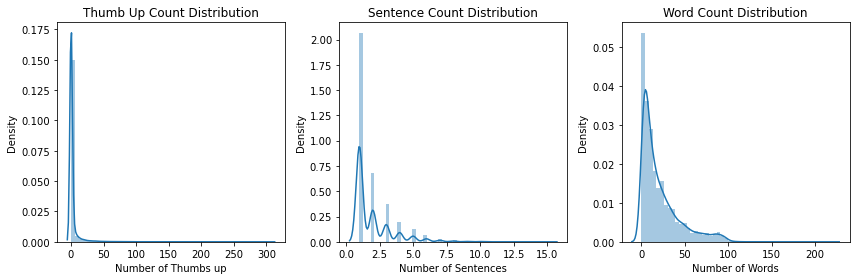

In [86]:
f, ax = plt.subplots(1,3,figsize=(12,4), sharey=False)
sns.distplot(app_reviews_df.thumbsUpCount, ax=ax[0])
ax[0].set_title("Thumb Up Count Distribution")
ax[0].set_xlabel("Number of Thumbs up")
sns.distplot(app_reviews_df.sentence_count, ax=ax[1])
ax[1].set_title("Sentence Count Distribution")
ax[1].set_xlabel("Number of Sentences")
sns.distplot(app_reviews_df.word_count, ax=ax[2])
ax[2].set_title("Word Count Distribution")
ax[2].set_xlabel("Number of Words")
plt.tight_layout()
plt.show()

Only abnormality was the comement with 0 words and 1 sentence, turns out is just a period. 

In [65]:
app_reviews_df.loc[app_reviews_df['word_count'] == 0]

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,reviews_in_sents,sentence_count,reviews_in_words,word_count
1723,gp:AOqpTOHDuXDtLQF95RQv3a3tvatO2XlzbGbdKK9p74v...,Mii,https://play-lh.googleusercontent.com/a-/AOh14...,.,3,0,1.27.6,2016-05-08 12:21:29,NaN,NaN,newest,com.morrisons.mobile.android,[.],1,[.],0


<ol start="8">
    <li>Count of review per app version.</li>
</ol>

In [143]:
app_reviews_df['ymd'] = [date.split(' ')[0] for date in app_reviews_df['at']]

In [161]:
app_reviews_df.loc[app_reviews_df['ymd'] >'2022-03-30']

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,reviews_in_sents,sentence_count,reviews_in_words,word_count,ymd
0,gp:AOqpTOHoLYWCleX8HM-fJST-nS6_Q7nRCKgUfcXviZW...,Joyce Jamieson,https://play-lh.googleusercontent.com/a/AATXAJ...,Found this confusing and difficult,1,0,19.29.0,2022-03-31 16:48:34,NaN,NaN,newest,com.tesco.grocery.view,[Found this confusing and difficult],1,"[Found, this, confusing, and, difficult]",5,2022-03-31
600,gp:AOqpTOEbDGZIeQKI9vWsHq7I-EwO42Zz0Ro2Az43zth...,Kerry Martin,https://play-lh.googleusercontent.com/a/AATXAJ...,Search is awful You have to be so specific. Al...,3,0,19.29.0,2022-03-31 18:11:11,NaN,NaN,newest,com.tesco.grocery.view,"[Search is awful You have to be so specific., ...",3,"[Search, is, awful, You, have, to, be, so, spe...",17,2022-03-31
750,gp:AOqpTOFONoo8JA2-MiIO82nMVDSCdPMu5J8cHstjExh...,sharon willems,https://play-lh.googleusercontent.com/a/AATXAJ...,Sometimes doubles my amounts,4,0,19.29.0,2022-03-31 18:49:13,NaN,NaN,newest,com.tesco.grocery.view,[Sometimes doubles my amounts],1,"[Sometimes, doubles, my, amounts]",4,2022-03-31
751,gp:AOqpTOHrfSJbx3zqcT0v2uRaNF1zWtAjfqczHhlSqBB...,John Craddock,https://play-lh.googleusercontent.com/a/AATXAJ...,when shopping from my list of favourites it wo...,4,0,19.29.0,2022-03-31 17:44:47,NaN,NaN,newest,com.tesco.grocery.view,[when shopping from my list of favourites it w...,1,"[when, shopping, from, my, list, of, favourite...",37,2022-03-31
752,gp:AOqpTOE8QJgu_owko_TJoYCSaBf_gGoRM_Ud6r7gUEh...,MasterLector,https://play-lh.googleusercontent.com/a-/AOh14...,Haven't had to change an option and have conta...,4,0,19.29.0,2022-03-31 16:37:57,NaN,NaN,newest,com.tesco.grocery.view,[Haven't had to change an option and have cont...,2,"[Haven't, had, to, change, an, option, and, ha...",31,2022-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7065,gp:AOqpTOHVHyLJT92ZW-wgKtB7sgauJlPksojrFYEr_y8...,Jenny Davies,https://play-lh.googleusercontent.com/a/AATXAJ...,Useless,1,0,2.7.3.2448,2022-03-31 13:41:59,NaN,NaN,newest,com.waitrose.groceries,[Useless],1,[Useless],1,2022-03-31
7066,gp:AOqpTOFOjNlB9foINrakA8n0IZypEALhUNjluf780hN...,Virginia Jones,https://play-lh.googleusercontent.com/a-/AOh14...,Pretty useless as when you get in the store th...,1,0,2.7.3.2448,2022-03-31 07:40:39,NaN,NaN,newest,com.waitrose.groceries,[Pretty useless as when you get in the store t...,1,"[Pretty, useless, as, when, you, get, in, the,...",31,2022-03-31
7480,gp:AOqpTOGhRa6SUYWN7QX2CBDUpG6DXiINokkOtvkx8pw...,cyril Halpenny,https://play-lh.googleusercontent.com/a/AATXAJ...,Confusing and slow to activate on my phone,3,0,2.7.0.2433,2022-03-31 11:37:20,NaN,NaN,newest,com.waitrose.groceries,[Confusing and slow to activate on my phone],1,"[Confusing, and, slow, to, activate, on, my, p...",8,2022-03-31
7860,gp:AOqpTOHNbnxwDfHxAcm5C3wvbgB1C4MhgfZzia8N3ZB...,Jo Jefferis,https://play-lh.googleusercontent.com/a-/AOh14...,Seamless and straightforward to use.,5,0,2.7.3.2448,2022-03-31 17:17:31,NaN,NaN,newest,com.waitrose.groceries,[Seamless and straightforward to use.],1,"[Seamless, and, straightforward, to, use, .]",5,2022-03-31


Number of reviews in the dataset 2022 split by stars

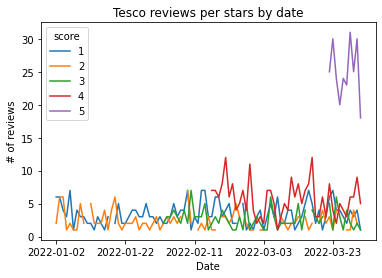

In [193]:
app_reviews_df.loc[(app_reviews_df['ymd']>'2022-01-01') & (app_reviews_df['appId'] == 'com.tesco.grocery.view') ].groupby(['ymd','score'])['score'].count().unstack().plot(legend=True)
plt.title('Tesco reviews per stars by date')
plt.xlabel('Date')
plt.ylabel('# of reviews')
plt.show()